In [299]:
import cv2
import numpy as np
import math

def auto_align_image(image, align_mode='outer', alignment_edge="center"):
    if align_mode == "outer":
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)
        edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        edges = cv2.bitwise_not(edges)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)
        if lines is not None:
            print("Debug: Found", len(lines), "lines.")
            angles = [np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi for line in lines for x1, y1, x2, y2 in [line[0]]]
            normalized_angles = [(angle + 180) % 180 - 90 for angle in angles]
            tolerance = 60
            close_angles = [angle for angle in normalized_angles if abs(angle) < tolerance]
            if close_angles:
                if alignment_edge == 'top':
                    center = (image.shape[1] // 2, 0)
                elif alignment_edge == 'bottom':
                    center = (image.shape[1] // 2, image.shape[0])
                elif alignment_edge == 'left':
                    center = (0, image.shape[0] // 2)
                elif alignment_edge == 'right':
                    center = (image.shape[1], image.shape[0] // 2)
                else:
                    center = (image.shape[1] // 2, image.shape[0] // 2)
                median_angle = np.median(close_angles)
                print("Debug: Median angle:", median_angle)
                
                rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
                aligned_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
                return aligned_image
    elif align_mode == "text":
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = cv2.bitwise_not(gray)
        edges = cv2.Canny(gray, 50, 150, apertureSize=3)
        lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=gray.shape[1] / 2.0, maxLineGap=20)
        
        if lines is not None:
            angles = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                angle = math.atan2(y2 - y1, x2 - x1)
                angles.append(angle)
            
            mean_angle = np.mean(angles)
            angle_in_degrees = mean_angle * 180 / np.pi
            print(f"Text alignment: {angle_in_degrees:.2f} degrees")
            
            center = (image.shape[1] // 2, image.shape[0] // 2)
            rotation_matrix = cv2.getRotationMatrix2D(center, angle_in_degrees, 1.0)
            rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
            return rotated_image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        median_intensity = np.median(gray)
        lower_threshold = int(max(0, (1.0 - 0.33) * median_intensity))
        upper_threshold = int(min(255, (1.0 + 0.33) * median_intensity))
        edges = cv2.Canny(gray, lower_threshold, upper_threshold)

        minLineLength = max(50, int(0.1 * max(image.shape)))
        maxLineGap = max(10, int(0.05 * max(image.shape)))
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap)

        if lines is not None:
            filtered_lines = []
            for line in lines:
                x1, y1, x2, y2 = line[0]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                if length > 100 and not (80 < abs(angle) < 100):
                    filtered_lines.append(line)

            angles = [np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi for line in filtered_lines]

            if angles:
                median_angle = np.median(angles)

                if alignment_edge == 'top':
                    center = (image.shape[1] // 2, 0)
                elif alignment_edge == 'bottom':
                    center = (image.shape[1] // 2, image.shape[0])
                elif alignment_edge == 'left':
                    center = (0, image.shape[0] // 2)
                elif alignment_edge == 'right':
                    center = (image.shape[1], image.shape[0] // 2)
                else:
                    center = (image.shape[1] // 2, image.shape[0] // 2)
                rotation_matrix = cv2.getRotationMatrix2D(center, median_angle, 1.0)
                aligned_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
                return aligned_image
            else:
                print("No valid angles found.")
                return image
        else:
            print("No lines detected.")
            return image
    return image

Debug: Found 50 lines.
Debug: Median angle: -5.135321477221623


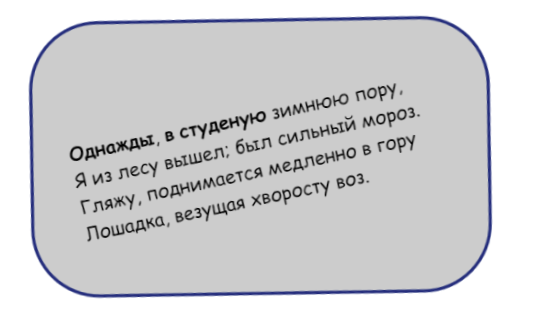

In [300]:
import cv2
from IPython.display import Image

def display_image(image):
    ret, encoded = cv2.imencode('.png', image)
    display(Image(data=encoded.tobytes()))


# Выравнивание по внешнему контуру (по умолчанию)
image = cv2.imread('test.png')
aligned_image = auto_align_image(image)
display_image(aligned_image)

Text alignment: -15.35 degrees


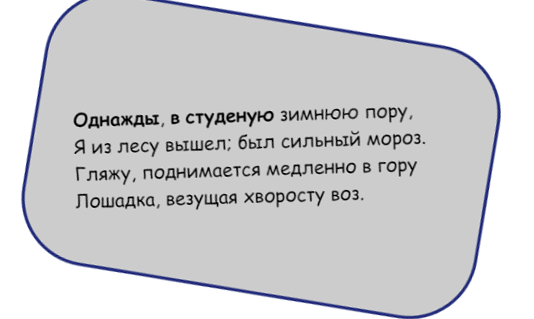

In [301]:
# Выравнивание по внутреннему содержимому (тексту)
aligned_image = auto_align_image(image, 'text')
display_image(aligned_image)

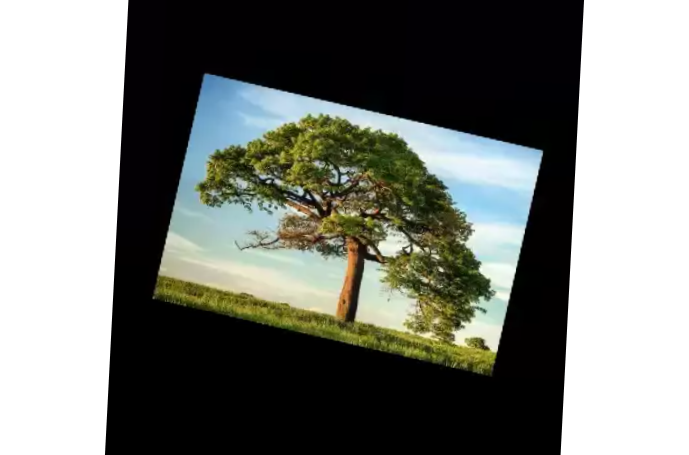

In [304]:
#Оставшийся метод выравнивания
image = cv2.imread('tree.png')
aligned_image = auto_align_image(image, align_mode='other', alignment_edge="")
display_image(aligned_image)

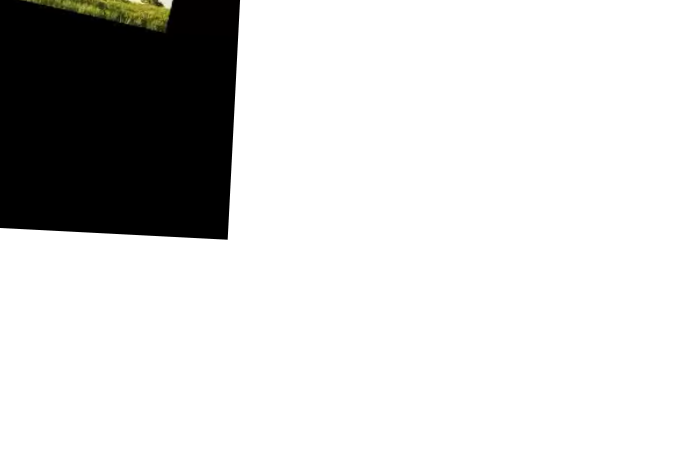

In [306]:
#Оставшийся метод выравнивания
aligned_image = auto_align_image(image, align_mode='inner', alignment_edge="left")
display_image(aligned_image)